In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

img_size = 32 #resize the MNIST images to this dimension 

#dataloader
from torch.utils.data import DataLoader
batch_size = 32

# #to circumvent the HTTP error (does not work)
# import urllib
# basepath = './content/drive/My Drive/'
# def set_header_for(url, filename):
#     opener = urllib.request.URLopener()
#     opener.addheader('User-Agent', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36')
#     opener.retrieve(
#     url, f'{basepath}/{filename}')

# set_header_for('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
# set_header_for('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


#dataloading
transform_train = transforms.Compose(
    [#transforms.RandomHorizontalFlip(),
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     ])

dataset = datasets.FashionMNIST(root='../data/FashionMNIST', train=True, transform=transform_train, download=True)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print('# training minibatches = %d'%len(train_loader))

cpu
# training minibatches = 1875


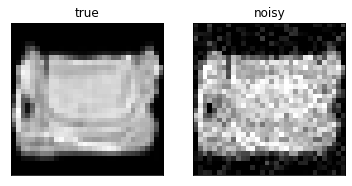

In [7]:
import matplotlib.pyplot as plt
#add noise, denoise using a prox. operator
noise_sd = 0.10
lambda_reg = 0.25
soft_shrink = nn.Softshrink(lambd=lambda_reg)

for idx, (images, labels) in enumerate(train_loader):
  x_true = images.to(device) #true images
  x_noisy = x_true + noise_sd*torch.randn(x_true.size()).to(device)
  x_soft_shrink = soft_shrink(x_noisy)
  #see true, noisy, and denoised
  x_true_im = x_true[0,:,:].cpu().detach().numpy().squeeze()
  x_noisy_im = x_noisy[0,:,:].cpu().detach().numpy().squeeze()
  x_soft_shrink_im = x_soft_shrink[0,:,:].cpu().detach().numpy().squeeze()

  plt.subplot(121)
  vmin, vmax = x_true_im.min(), x_true_im.max()
  plt.imshow(x_true_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('true')

  plt.subplot(122)
  plt.imshow(x_noisy_im,cmap='gray',vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  plt.title('noisy')

#   plt.subplot(133)
#   plt.imshow(x_soft_shrink_im,cmap='gray',vmin=vmin, vmax=vmax)
#   plt.xticks([])
#   plt.yticks([])
#   plt.title('soft-shrinkage')

  plt.gcf().set_size_inches(6.0, 4.0)

  break

In [8]:
#unrolled gradient network
n_filters = 16
n_in_channels = 1
tau = 0.01*torch.ones(1).to(device)

class cnn_image_space(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=n_filters): #2 input channels, 1 for image, 1 for noisy data
        super(cnn_image_space, self).__init__()
        
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True)
        
        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)
        
    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return dx
    
class unrolled_gradient_model(nn.Module):
    def __init__(self, niter=5, tau=tau): #niter=10 worked quite well
        super(unrolled_gradient_model, self).__init__()
        
        self.niter = niter
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))
        self.cnn_image_layers = nn.ModuleList([cnn_image_space().to(device) for i in range(self.niter)])
        
    def forward(self, y): #y = noisy data
        x = y
        for iteration in range(self.niter):
            x = x - self.tau[iteration] * self.cnn_image_layers[iteration](x, y) # x = x - step_size*dx
        return x

net = unrolled_gradient_model().to(device)

In [9]:
from pytorch_wavelets import DWTForward
def wavelet_l1_penalty(network_output):
    J = 4
    xfm = DWTForward(J=J).to(device)  # We can use up to two since we can only divide 28 nicely through 4 (=2x2)
    Yl, Yh = xfm(network_output)
    penalty = torch.sum(torch.abs(Yl))
    for i in range(J):
        penalty += torch.sum(torch.abs(Yh[i]))
        
    return penalty

epoch[1/10] mini-batch[200/1875] avg_prox_loss 1297.325929:


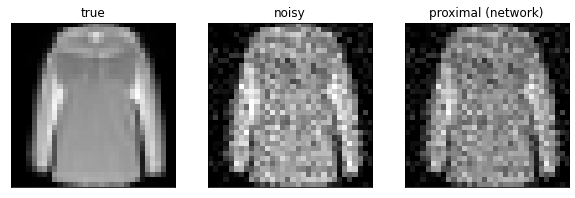

epoch[1/10] mini-batch[400/1875] avg_prox_loss 1120.699369:


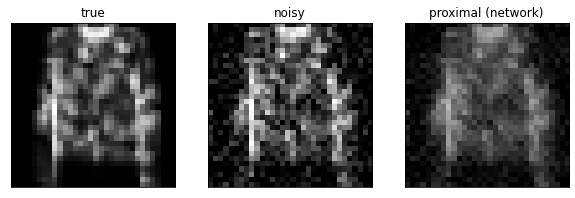

epoch[1/10] mini-batch[600/1875] avg_prox_loss 979.350475:


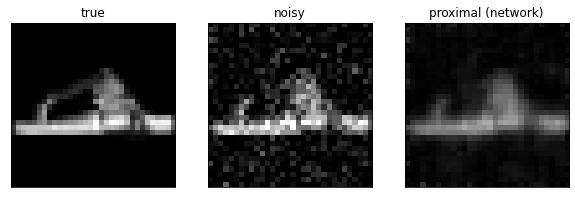

epoch[1/10] mini-batch[800/1875] avg_prox_loss 945.784496:


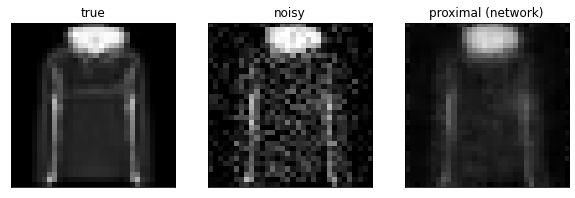

epoch[1/10] mini-batch[1000/1875] avg_prox_loss 934.569962:


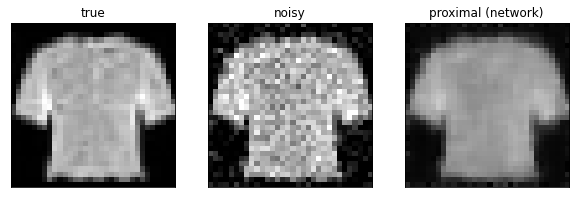

epoch[1/10] mini-batch[1200/1875] avg_prox_loss 931.641115:


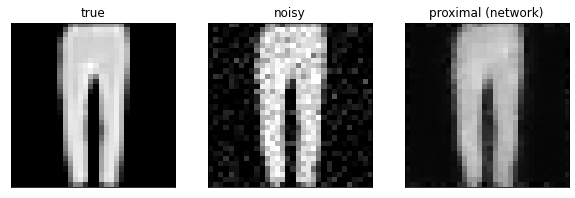

epoch[1/10] mini-batch[1400/1875] avg_prox_loss 918.906776:


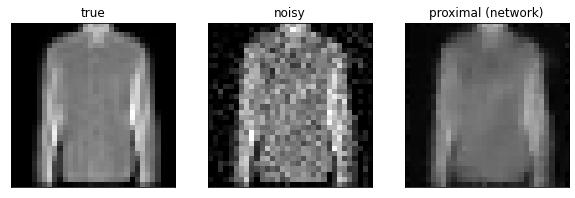

epoch[1/10] mini-batch[1600/1875] avg_prox_loss 912.339442:


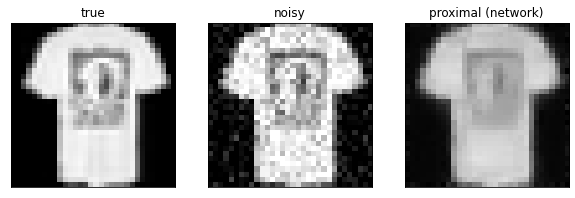

epoch[1/10] mini-batch[1800/1875] avg_prox_loss 914.346328:


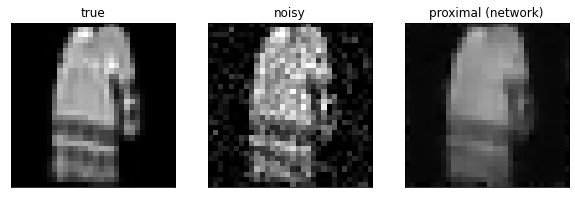

epoch[2/10] mini-batch[200/1875] avg_prox_loss 907.890425:


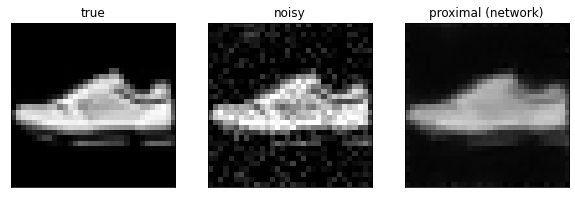

epoch[2/10] mini-batch[400/1875] avg_prox_loss 900.015526:


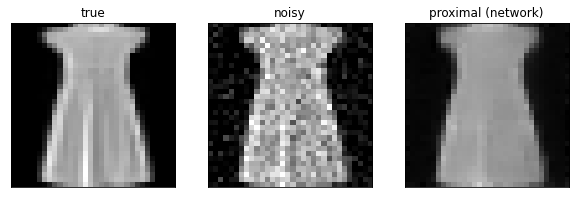

epoch[2/10] mini-batch[600/1875] avg_prox_loss 895.533714:


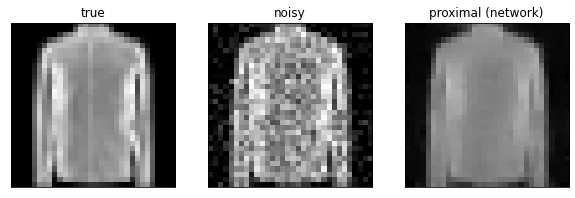

epoch[2/10] mini-batch[800/1875] avg_prox_loss 897.566833:


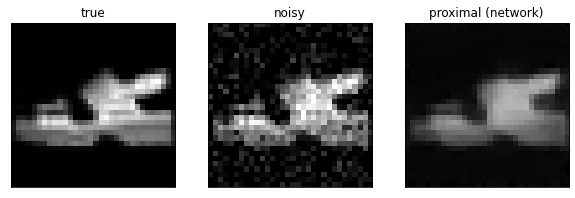

epoch[2/10] mini-batch[1000/1875] avg_prox_loss 896.280821:


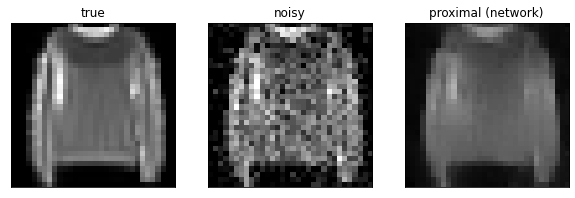

epoch[2/10] mini-batch[1200/1875] avg_prox_loss 892.052747:


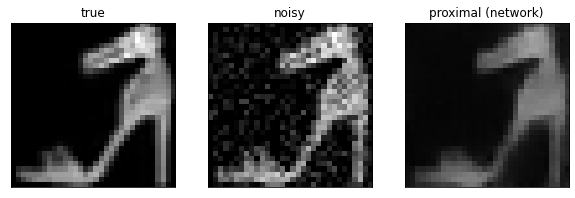

epoch[2/10] mini-batch[1400/1875] avg_prox_loss 886.138729:


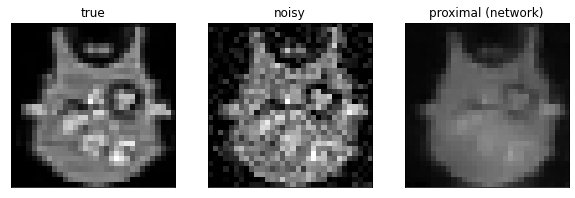

epoch[2/10] mini-batch[1600/1875] avg_prox_loss 888.294746:


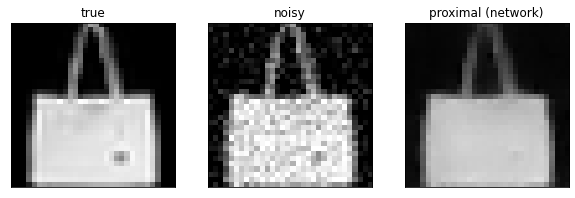

epoch[2/10] mini-batch[1800/1875] avg_prox_loss 885.349932:


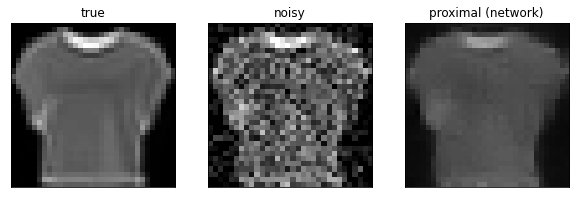

epoch[3/10] mini-batch[200/1875] avg_prox_loss 884.678183:


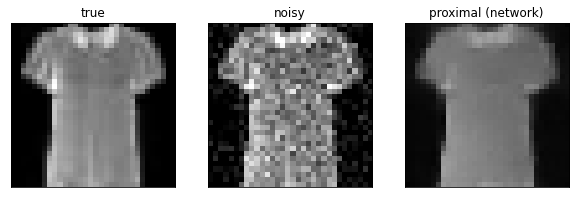

epoch[3/10] mini-batch[400/1875] avg_prox_loss 881.263025:


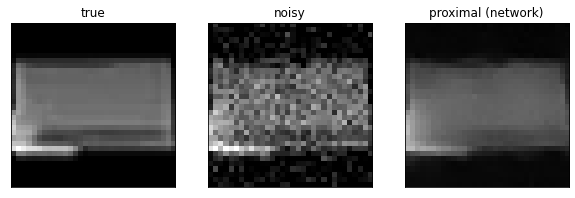

epoch[3/10] mini-batch[600/1875] avg_prox_loss 884.518493:


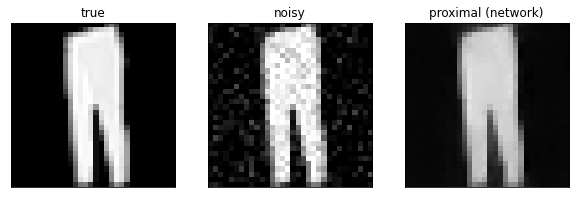

epoch[3/10] mini-batch[800/1875] avg_prox_loss 883.688199:


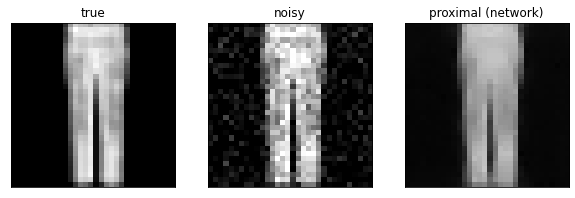

epoch[3/10] mini-batch[1000/1875] avg_prox_loss 885.000662:


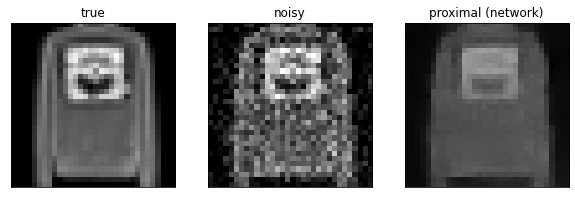

epoch[3/10] mini-batch[1200/1875] avg_prox_loss 880.313854:


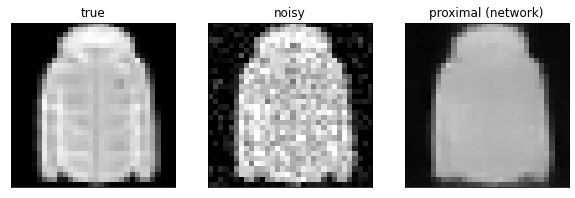

epoch[3/10] mini-batch[1400/1875] avg_prox_loss 884.786127:


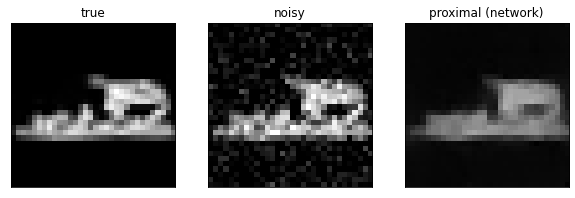

epoch[3/10] mini-batch[1600/1875] avg_prox_loss 885.369004:


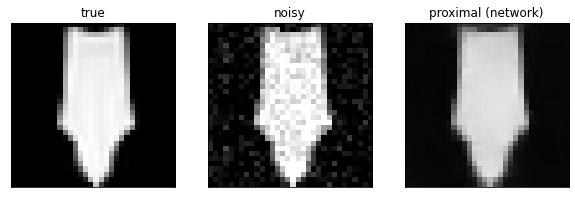

epoch[3/10] mini-batch[1800/1875] avg_prox_loss 877.084142:


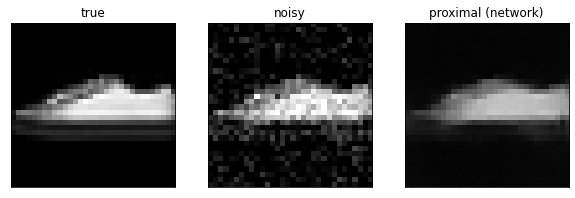

epoch[4/10] mini-batch[200/1875] avg_prox_loss 875.934102:


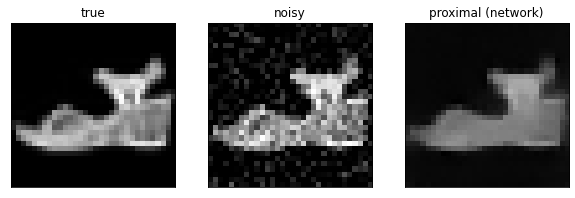

epoch[4/10] mini-batch[400/1875] avg_prox_loss 881.933833:


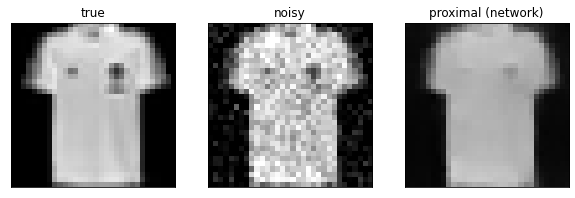

epoch[4/10] mini-batch[600/1875] avg_prox_loss 880.726119:


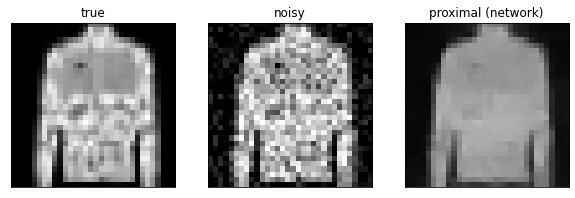

epoch[4/10] mini-batch[800/1875] avg_prox_loss 881.273784:


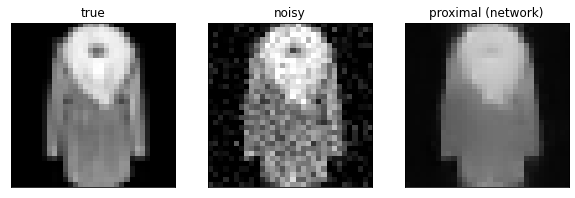

epoch[4/10] mini-batch[1000/1875] avg_prox_loss 879.721960:


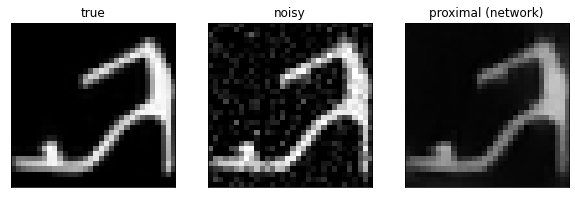

epoch[4/10] mini-batch[1200/1875] avg_prox_loss 875.794398:


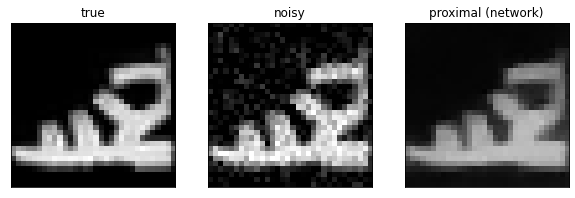

epoch[4/10] mini-batch[1400/1875] avg_prox_loss 877.388671:


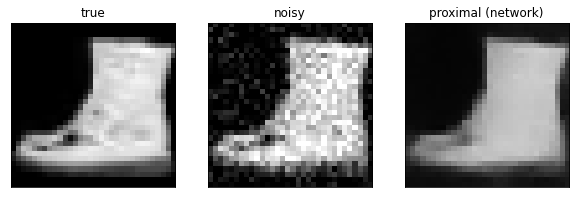

epoch[4/10] mini-batch[1600/1875] avg_prox_loss 877.575699:


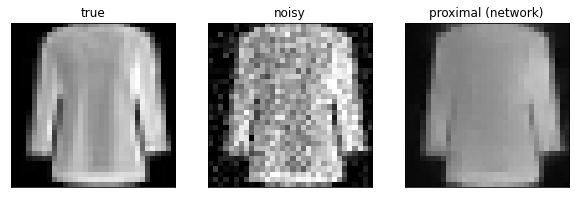

epoch[4/10] mini-batch[1800/1875] avg_prox_loss 878.207666:


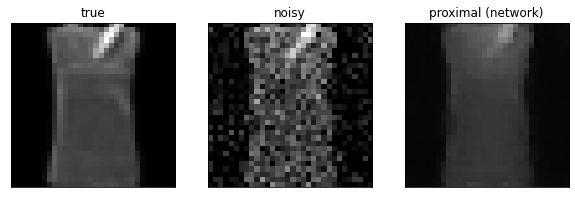

epoch[5/10] mini-batch[200/1875] avg_prox_loss 878.172703:


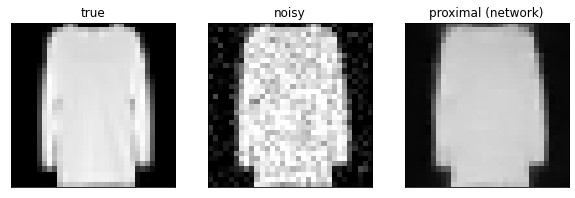

epoch[5/10] mini-batch[400/1875] avg_prox_loss 879.016601:


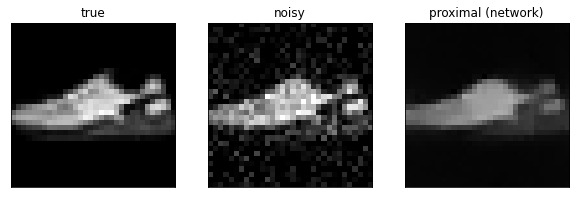

epoch[5/10] mini-batch[600/1875] avg_prox_loss 878.231286:


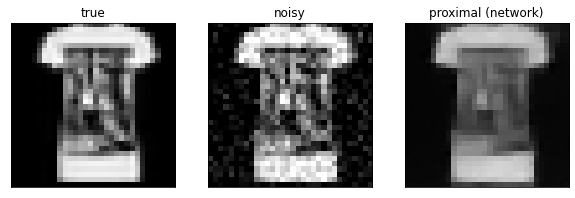

epoch[5/10] mini-batch[800/1875] avg_prox_loss 874.648150:


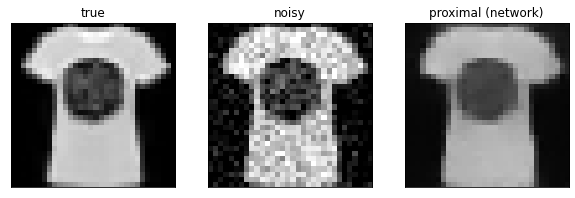

epoch[5/10] mini-batch[1000/1875] avg_prox_loss 876.185269:


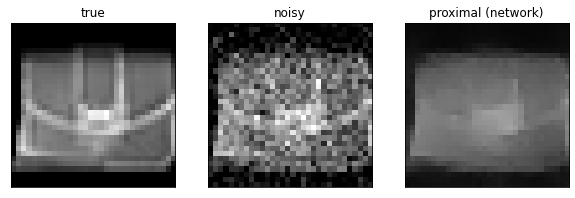

epoch[5/10] mini-batch[1200/1875] avg_prox_loss 873.361960:


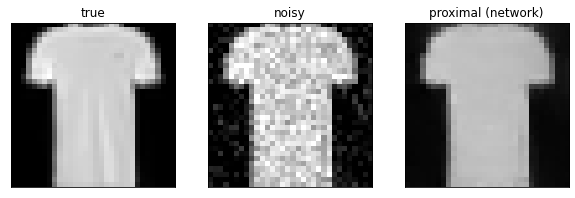

epoch[5/10] mini-batch[1400/1875] avg_prox_loss 875.036271:


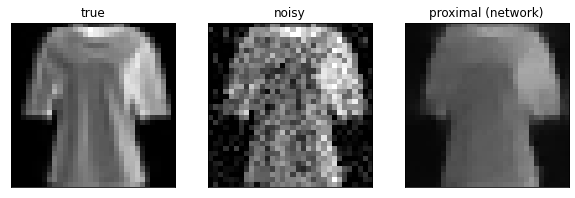

epoch[5/10] mini-batch[1600/1875] avg_prox_loss 874.515458:


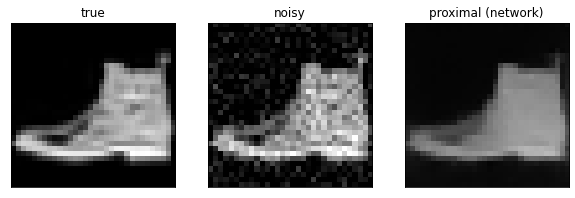

epoch[5/10] mini-batch[1800/1875] avg_prox_loss 879.720849:


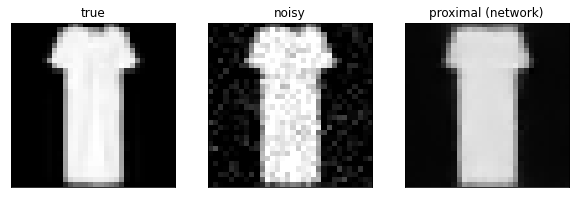

epoch[6/10] mini-batch[200/1875] avg_prox_loss 876.394539:


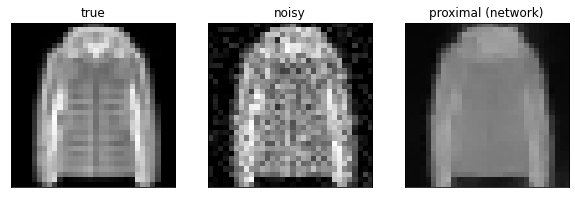

epoch[6/10] mini-batch[400/1875] avg_prox_loss 877.621870:


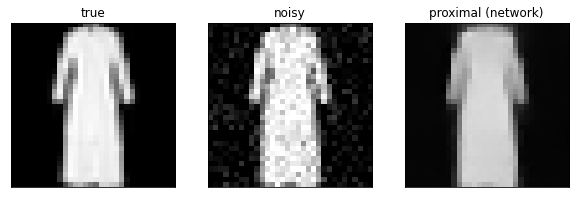

epoch[6/10] mini-batch[600/1875] avg_prox_loss 873.923744:


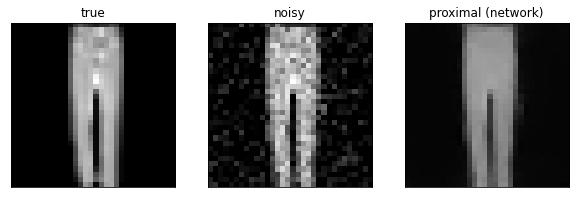

epoch[6/10] mini-batch[800/1875] avg_prox_loss 870.393023:


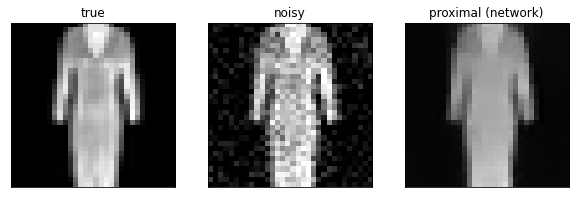

epoch[6/10] mini-batch[1000/1875] avg_prox_loss 875.350782:


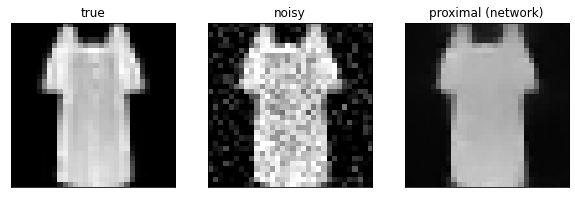

epoch[6/10] mini-batch[1200/1875] avg_prox_loss 875.463497:


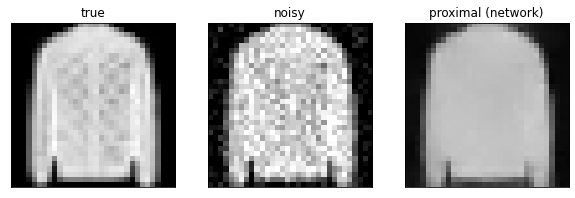

epoch[6/10] mini-batch[1400/1875] avg_prox_loss 874.403245:


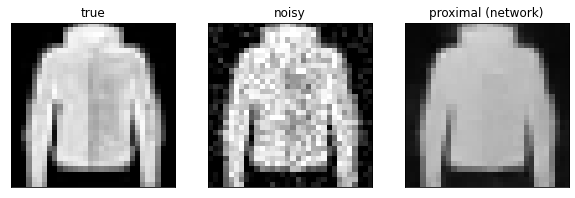

epoch[6/10] mini-batch[1600/1875] avg_prox_loss 876.840074:


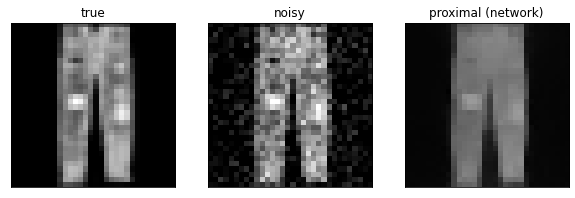

epoch[6/10] mini-batch[1800/1875] avg_prox_loss 869.655002:


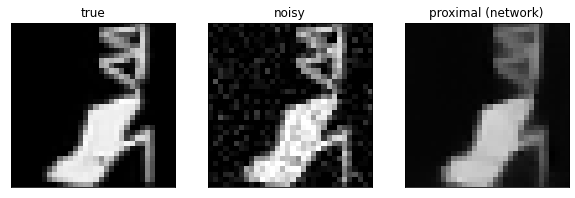

epoch[7/10] mini-batch[200/1875] avg_prox_loss 877.978144:


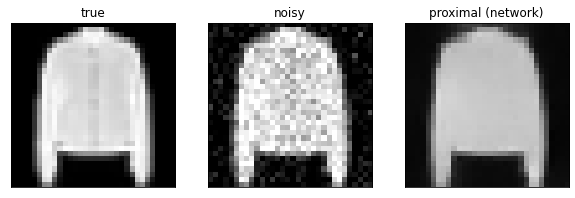

epoch[7/10] mini-batch[400/1875] avg_prox_loss 871.885921:


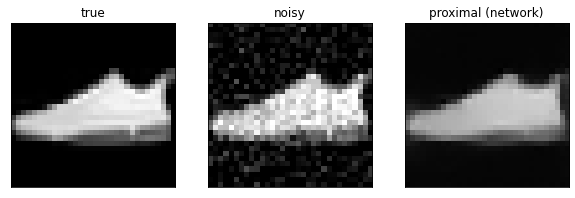

epoch[7/10] mini-batch[600/1875] avg_prox_loss 870.913849:


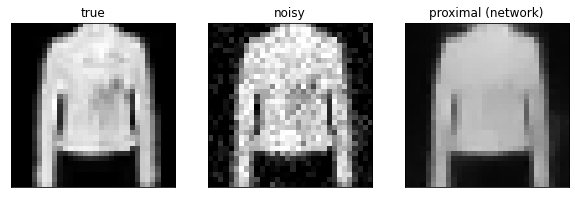

epoch[7/10] mini-batch[800/1875] avg_prox_loss 874.309641:


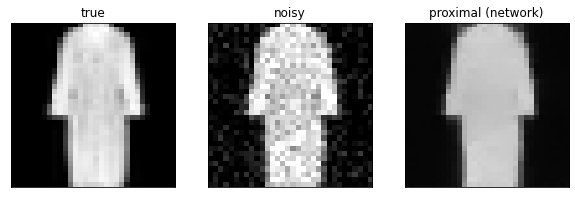

epoch[7/10] mini-batch[1000/1875] avg_prox_loss 870.191319:


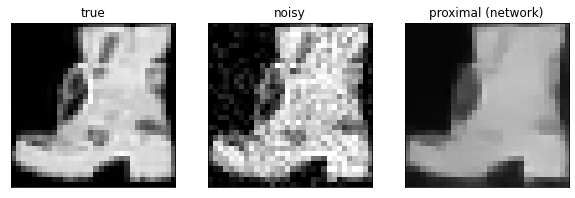

epoch[7/10] mini-batch[1200/1875] avg_prox_loss 871.436890:


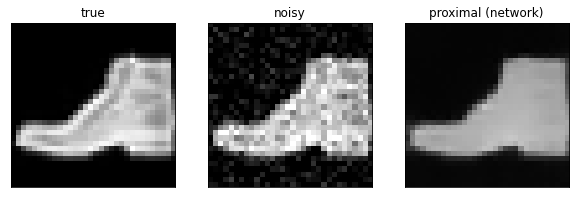

epoch[7/10] mini-batch[1400/1875] avg_prox_loss 870.491951:


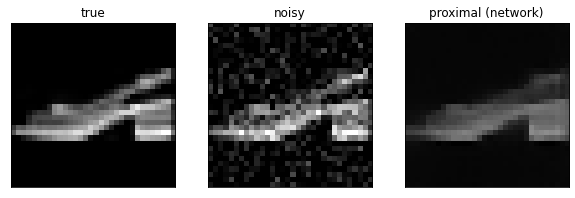

epoch[7/10] mini-batch[1600/1875] avg_prox_loss 871.486501:


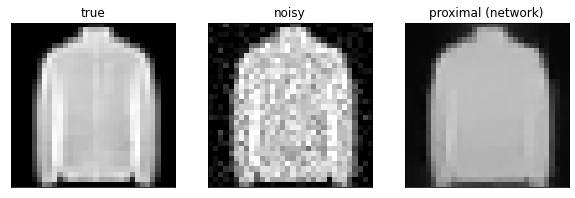

epoch[7/10] mini-batch[1800/1875] avg_prox_loss 872.550533:


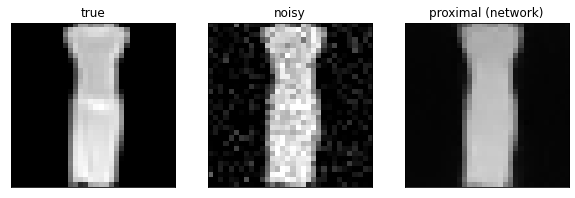

epoch[8/10] mini-batch[200/1875] avg_prox_loss 867.597047:


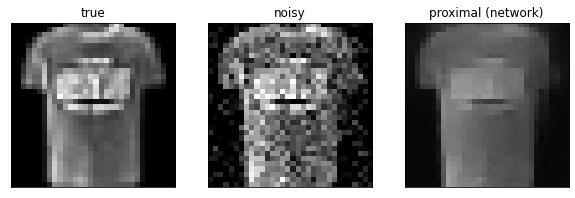

epoch[8/10] mini-batch[400/1875] avg_prox_loss 873.092300:


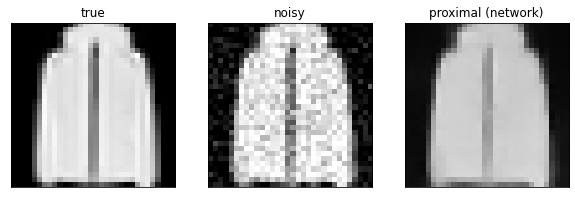

epoch[8/10] mini-batch[600/1875] avg_prox_loss 874.871302:


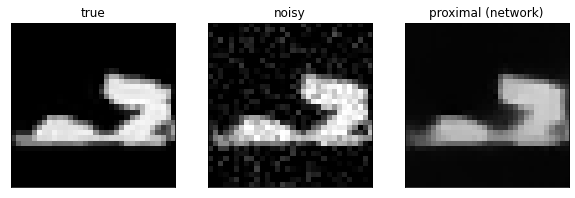

epoch[8/10] mini-batch[800/1875] avg_prox_loss 865.946776:


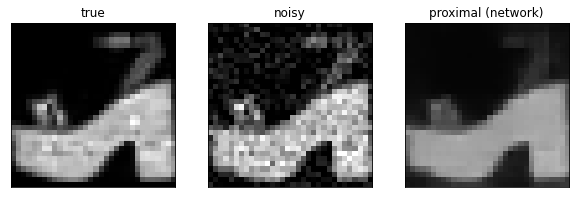

epoch[8/10] mini-batch[1000/1875] avg_prox_loss 869.614748:


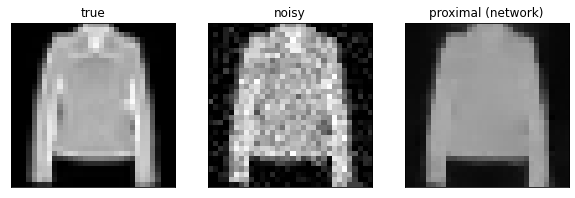

epoch[8/10] mini-batch[1200/1875] avg_prox_loss 871.656649:


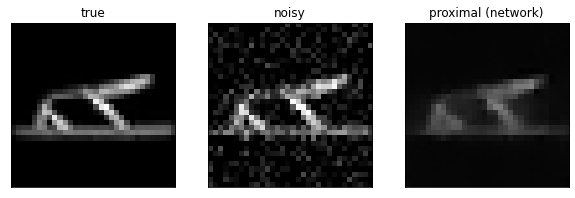

epoch[8/10] mini-batch[1400/1875] avg_prox_loss 869.356392:


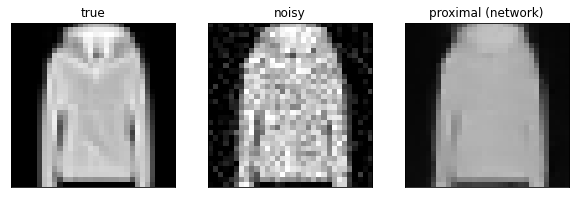

epoch[8/10] mini-batch[1600/1875] avg_prox_loss 865.693435:


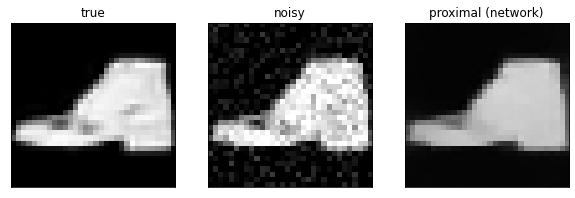

epoch[8/10] mini-batch[1800/1875] avg_prox_loss 870.684318:


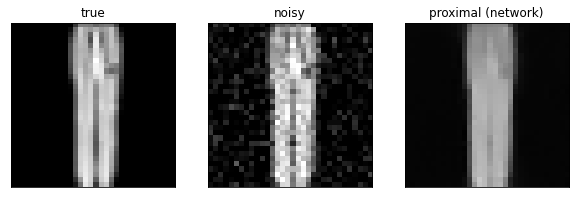

epoch[9/10] mini-batch[200/1875] avg_prox_loss 870.628128:


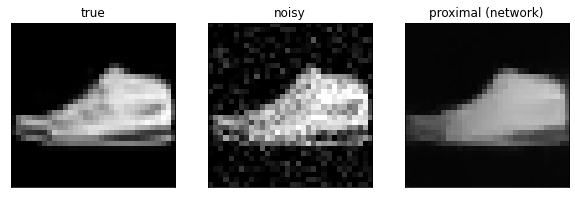

epoch[9/10] mini-batch[400/1875] avg_prox_loss 865.548480:


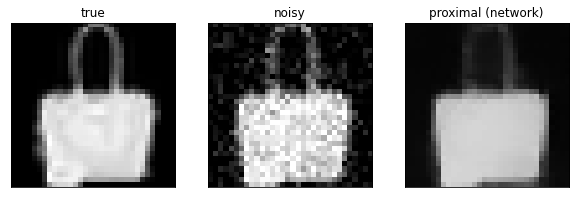

epoch[9/10] mini-batch[600/1875] avg_prox_loss 870.439322:


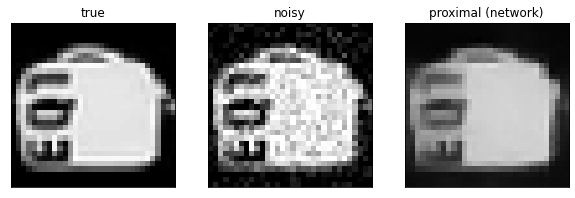

epoch[9/10] mini-batch[800/1875] avg_prox_loss 868.158598:


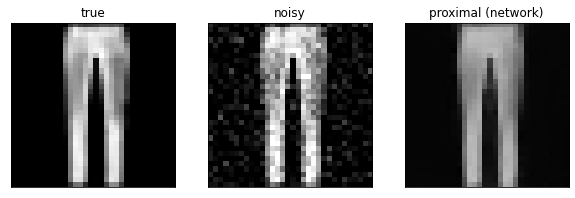

epoch[9/10] mini-batch[1000/1875] avg_prox_loss 868.213734:


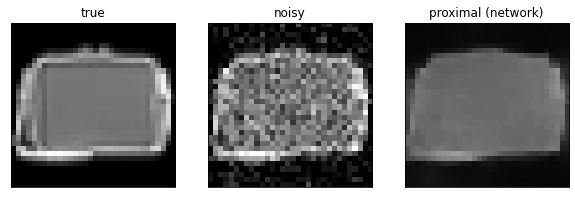

epoch[9/10] mini-batch[1200/1875] avg_prox_loss 865.034148:


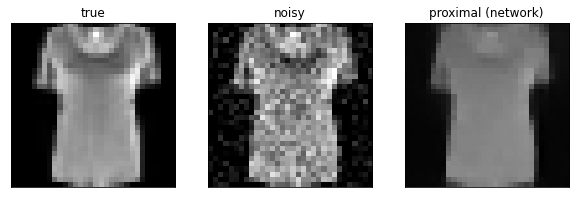

epoch[9/10] mini-batch[1400/1875] avg_prox_loss 868.817929:


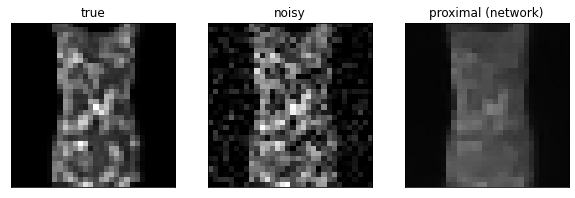

epoch[9/10] mini-batch[1600/1875] avg_prox_loss 870.546180:


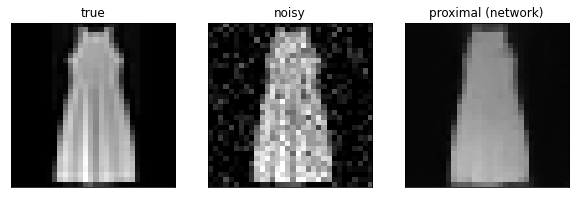

epoch[9/10] mini-batch[1800/1875] avg_prox_loss 868.085043:


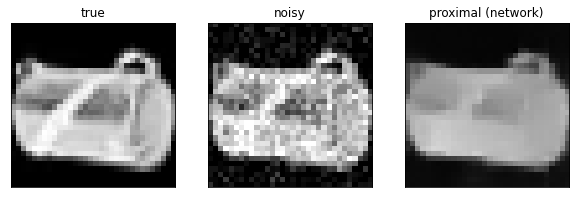

epoch[10/10] mini-batch[200/1875] avg_prox_loss 866.498091:


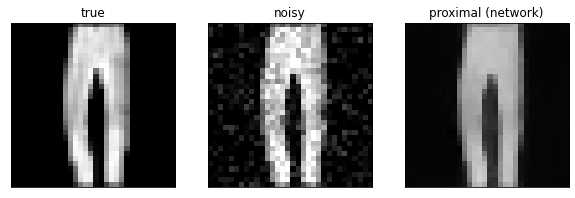

epoch[10/10] mini-batch[400/1875] avg_prox_loss 867.483125:


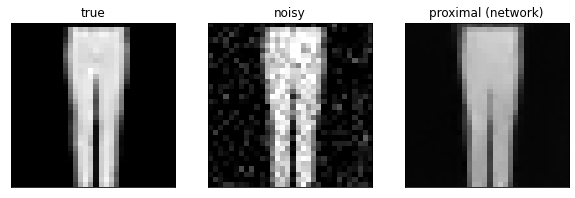

epoch[10/10] mini-batch[600/1875] avg_prox_loss 865.630468:


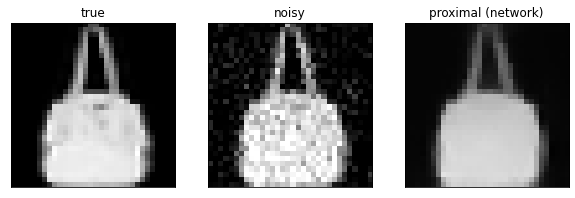

epoch[10/10] mini-batch[800/1875] avg_prox_loss 866.579377:


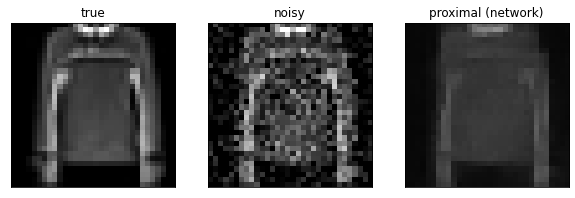

epoch[10/10] mini-batch[1000/1875] avg_prox_loss 866.348085:


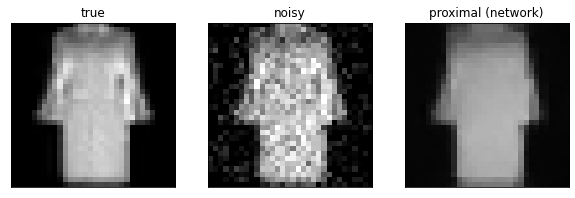

epoch[10/10] mini-batch[1200/1875] avg_prox_loss 867.775911:


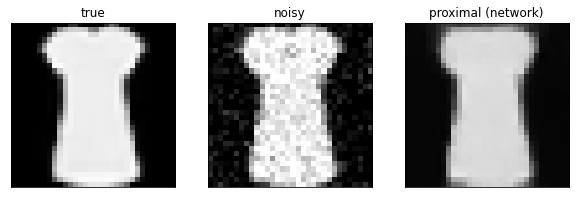

epoch[10/10] mini-batch[1400/1875] avg_prox_loss 864.594734:


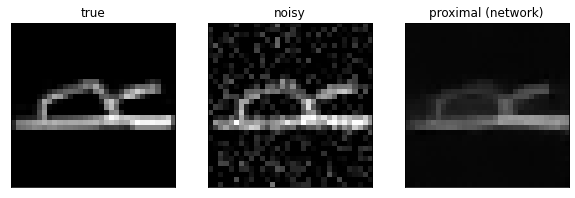

epoch[10/10] mini-batch[1600/1875] avg_prox_loss 868.744131:


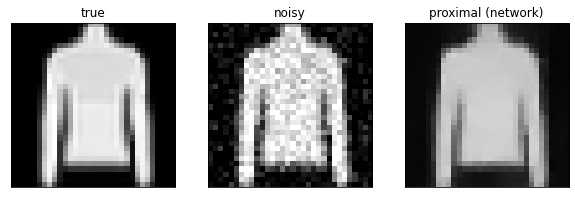

epoch[10/10] mini-batch[1800/1875] avg_prox_loss 865.270418:


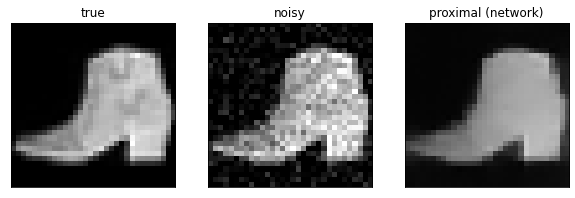

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9,0.99))

#main training loop
n_epochs = 10
num_minibatches = 200 #display the loss after these many mini-batches


for epoch in np.arange(n_epochs):
    total_prox_loss = 0.0
      
    for idx, (images, labels) in enumerate(train_loader):
        x_true = images.to(device) #true images
        x_noisy = x_true + noise_sd*torch.randn(x_true.size()).to(device)
        
        #optimize the net
        network_output = net(x_noisy)
        wavelet_penalty = wavelet_l1_penalty(network_output)
        prox_loss = 0.5*torch.sum((network_output - x_noisy)**2) + lambda_reg * wavelet_penalty #loss as a function of net parameters. net approximates arg_min_x (proximal obj)

        #update networks
        optimizer.zero_grad()
        prox_loss.backward()
        optimizer.step()

        total_prox_loss += prox_loss.item()

        if(idx % num_minibatches == num_minibatches-1):
            avg_prox_loss = total_prox_loss/num_minibatches
            
            print("epoch[{}/{}] mini-batch[{}/{}] avg_prox_loss {:.6f}:"\
                  .format(epoch+1, n_epochs, idx+1, len(train_loader), avg_prox_loss))
            total_prox_loss = 0.0
            
            #see true, noisy, and denoised for one image in the batch
            x_true_im = x_true[0,:,:].cpu().detach().numpy().squeeze()
            x_noisy_im = x_noisy[0,:,:].cpu().detach().numpy().squeeze()
            x_soft_shrink_im = x_soft_shrink[0,:,:].cpu().detach().numpy().squeeze()

            plt.subplot(131)
            vmin, vmax = x_true_im.min(), x_true_im.max()
            plt.imshow(x_true_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('true')

            plt.subplot(132)
            plt.imshow(x_noisy_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('noisy')

#             plt.subplot(153)
#             plt.imshow(x_soft_shrink_im,cmap='gray',vmin=vmin, vmax=vmax)
#             plt.xticks([])
#             plt.yticks([])
#             plt.title('proximal (true)')

            plt.subplot(133)
            x_soft_shrink_net_im = network_output[0,:,:].cpu().detach().numpy().squeeze()
            plt.imshow(x_soft_shrink_net_im,cmap='gray',vmin=vmin, vmax=vmax)
            plt.xticks([])
            plt.yticks([])
            plt.title('proximal (network)')

#             plt.subplot(144)
#             diff_image = np.abs(x_soft_shrink_net_im-x_soft_shrink_im)
#             plt.imshow(diff_image,cmap='gray',vmin=vmin, vmax=vmax)
#             plt.xticks([])
#             plt.yticks([])
#             plt.title('diff.')

            plt.gcf().set_size_inches(10.0, 4.0)
            plt.show()

In [11]:
#save the models
pretrained_network_path = '../models/unrolled_gradient_pretrained_nets/'
os.makedirs(pretrained_network_path, exist_ok=True)
torch.save(net.state_dict(),  pretrained_network_path + "l1dwt_prox_model_" + 'epoch_%02d'%epoch + ".pt") 